<a href="https://colab.research.google.com/github/manteshswami/Explainable-AI/blob/main/Explainable_AI_(XAI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Explainable AI (XAI)**

Grad-CAM helps visualize where a CNN model focuses in an image while making predictions, making the model more interpretable and trustworthy.

In [1]:
import torch
torch.cuda.is_available()

True

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

3.10.0
2.19.0


In [3]:
keras.backend.backend()

'tensorflow'

In [12]:
import torch
import cv2
import numpy as np
from torchvision import models, transforms
from PIL import Image

# Load pretrained CNN
model = models.resnet18(weights=True)
model.eval()

# Image preprocess
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

img = Image.open("/content/dog.avif")   # any image
input_tensor = transform(img).unsqueeze(0)

# Hook for gradients
gradients = None
def save_grad(grad):
    global gradients
    gradients = grad

# Hook for feature maps
feature_maps = None
def save_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output

# Last conv layer
last_conv = model.layer4

# Register both hooks
last_conv.register_forward_hook(save_feature_maps)
last_conv.register_backward_hook(lambda m, g_in, g_out: save_grad(g_out[0]))

# Forward pass
output = model(input_tensor)
class_idx = output.argmax()
output[0, class_idx].backward()

# Grad-CAM heatmap
pooled_grad = torch.mean(gradients, dim=[0,2,3])
# Use the captured feature_maps from the forward hook
feature_map = feature_maps.detach()

for i in range(feature_map.shape[1]):
    feature_map[:, i, :, :] *= pooled_grad[i]

heatmap = torch.mean(feature_map, dim=1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

print("Grad-CAM generated successfully!")

Grad-CAM generated successfully!


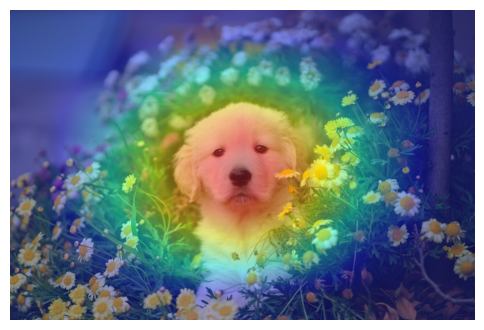

In [13]:
import matplotlib.pyplot as plt

# Convert heatmap to image
# Ensure heatmap is a numpy array before passing to cv2.resize
heatmap = heatmap.cpu().numpy()
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)

# Apply color map
colored_map = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Original image
original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Overlay
superimposed = cv2.addWeighted(original, 0.6, colored_map, 0.4, 0)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()